# ArcFace Explained

In [ ]:
pip install fastai --upgrade

In [ ]:
from fastai.vision import *
from tqdm.notebook import tqdm
from torch import nn
import torch
import torchvision
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from fastai.vision.all import *


In [ ]:
emb_size = 3
output_classes = 10
batch_size = 1 # for illustration only

In [ ]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, emb_size, output_classes):
        super().__init__()
        self.W = nn.Parameter(torch.Tensor(emb_size, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        # Step 1:
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        # Step 2:
        return x_norm @ W_norm
    
def arcface_loss(cosine, targ, m=0.1):
    # this prevents nan when a value slightly crosses 1.0 due to numerical error
    cosine = cosine.clip(-1+1e-7, 1-1e-7) 
    # Step 3:
    arcosine = cosine.arccos()
    # Step 4:
    arcosine += F.one_hot(targ, num_classes = output_classes) * m
    # Step 5:
    cosine2 = arcosine.cos()
    # Step 6:
    return F.cross_entropy(cosine2, targ)

#### The model:

In [ ]:
# a very basic network, just four strided convolutions, batch norm and ReLu
class SimpleConv(nn.Module):
    def __init__(self, classifier):
        super().__init__()
        ch_in=[3,6,12,24]
        convs = [ConvLayer(c, c*2, stride=2) for c in ch_in]
        convs += [AdaptiveAvgPool(), Flatten(), nn.Linear(48, emb_size)]
        self.convs = nn.Sequential(*convs)
        self.classifier = classifier
        
    def get_embs(self, x):
        return self.convs(x)
    
    def forward(self, x):
        x = self.get_embs(x)
        x = self.classifier(x)
        return x

model = SimpleConv(ArcFaceClassifier(3,10))

In [ ]:
# [ConvLayer(c, c*2, stride=2) for c in ch_in]

NameError: ignored

In [ ]:
# # helper method to extract all embedings from a data loader
# def get_embs(model, dl):
#     embs = []
#     ys = []
#     for bx,by in tqdm(dl):
#         with torch.no_grad():
#             embs.append(model.get_embs(bx))
#             ys.append(by)
#     embs = torch.cat(embs)
#     embs = embs / embs.norm(p=2,dim=1)[:,None]
#     ys = torch.cat(ys)
#     return embs,ys

# # helper to plot embeddings in 3D
# def plot_embs(embs, ys, ax):
#     #ax.axis('off')
#     for k in range(10):
#         e = embs[ys==k].cpu()
#         ax.scatter(e[:,0], e[:,1], e[:,2], s=4, alpha=.2)   


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

trainset = datasets.CIFAR10('~/.pytorch/CIFAR10/', download=True, train=True, transform=transform)
training_loader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

testset = datasets.CIFAR10('~/.pytorch/CIFAR10/', download=True, train=False, transform=transform)
validation_loader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True)

# Report split sizes
print('Training set has {} instances'.format(len(trainset)))
print('Validation set has {} instances'.format(len(testset)))


Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


In [ ]:

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

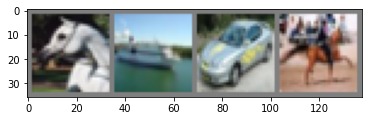

horse ship  car   horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(training_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
from fastai.vision.all import *
from tqdm.notebook import tqdm

In [ ]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    # optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)
    
        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = arcface_loss(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model.to(device)
EPOCHS = 35

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
        voutputs = model(vinputs)
        vloss = arcface_loss (voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 2.2553534586429596
  batch 2000 loss: 2.166006645321846
  batch 3000 loss: 2.1008042489290237
  batch 4000 loss: 2.0755107510089874
  batch 5000 loss: 2.0631746255159378
  batch 6000 loss: 2.044986601352692
  batch 7000 loss: 2.0197797232866286
  batch 8000 loss: 2.00425949215889
  batch 9000 loss: 1.9987407584190369
  batch 10000 loss: 1.9831134333610534
  batch 11000 loss: 1.9993083597421646
  batch 12000 loss: 1.9821002910137175
LOSS train 1.9821002910137175 valid 1.8941928148269653
EPOCH 2:
  batch 1000 loss: 1.9660009497404098
  batch 2000 loss: 1.970484961628914
  batch 3000 loss: 1.9553277590274811
  batch 4000 loss: 1.9636468222141266
  batch 5000 loss: 1.9549851380586625
  batch 6000 loss: 1.9439874002933502
  batch 7000 loss: 1.9194374072551728
  batch 8000 loss: 1.9173705459833146
  batch 9000 loss: 1.9253908327817917
  batch 10000 loss: 1.9274753671884537
  batch 11000 loss: 1.930663759946823
  batch 12000 loss: 1.935006982088089
LOSS train 1.935

In [ ]:
def validate(testloader):
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  model.to(device)
  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in testloader:
          images, labels = data[0].to(device), data[1].to(device)
          # calculate outputs by running images through the network
          outputs = model(images)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [ ]:
validate(validation_loader)

Accuracy of the network on the 10000 test images: 46 %
